### 🐼 or 🐻  
### 판다 곰 이진 분류

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/PandasBears/original/'

idg = ImageDataGenerator()

generator = idg.flow_from_directory(root, target_size=(224, 224), batch_size=32, class_mode='binary')
print(generator.class_indices)

Found 600 images belonging to 2 classes.
{'Bears': 0, 'Pandas': 1}


In [6]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'Bears', 1: 'Pandas'}

In [7]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [8]:
import pandas as pd

df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
df.file_paths = df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
df

,file_paths,target_names,targets
0,./datasets/PandasBears/original/Bears/1.jpeg,Bears,0
1,./datasets/PandasBears/original/Bears/10.jpeg,Bears,0
2,./datasets/PandasBears/original/Bears/100.jpeg,Bears,0
3,./datasets/PandasBears/original/Bears/101.jpeg,Bears,0
4,./datasets/PandasBears/original/Bears/102.jpeg,Bears,0
...,...,...,...
595,./datasets/PandasBears/original/Pandas/95.jpeg,Pandas,1
596,./datasets/PandasBears/original/Pandas/96.jpeg,Pandas,1
597,./datasets/PandasBears/original/Pandas/97.jpeg,Pandas,1
598,./datasets/PandasBears/original/Pandas/98.jpeg,Pandas,1


In [9]:
df.targets.value_counts()

targets
0    300
1    300
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(df.file_paths, 
                 df.targets, 
                 stratify=df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
0    240
1    240
Name: count, dtype: int64
targets
1    60
0    60
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
1    192
0    192
Name: count, dtype: int64
targets
1    48
0    48
Name: count, dtype: int64
targets
1    60
0    60
Name: count, dtype: int64


In [12]:
train_df = df.iloc[train_images.index].reset_index(drop=True)
validation_df = df.iloc[validation_images.index].reset_index(drop=True)
test_df = df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(384, 3)
(96, 3)
(120, 3)


#### 📌 IMAGE 확인

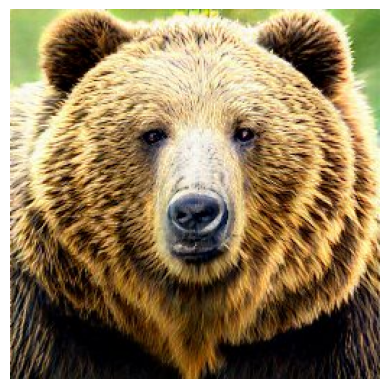

In [13]:
import cv2 
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[77]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 150
BATCH_SIZE = 8

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.Compose([A.HorizontalFlip(p=0.5), 
                     A.VerticalFlip(p=0.5), 
                     A.OneOf([A.ColorJitter(p=1), 
                              A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)], 
                             p=1)], p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)


# flow_from_dataframe에서 y_col에 들어갈 타겟 데이터는 문자열 타입만 가능하다.
train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 384 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
{'Bears': 0, 'Pandas': 1}
{'Bears': 0, 'Pandas': 1}
{'Bears': 0, 'Pandas': 1}


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/PandasBears/mobilenet/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.keras",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

### 🖥️ Cycle 1. MobileNet

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(1.0000e-05), loss=BinaryCrossentropy(), metrics=['acc'])

C:\Users\user\AppData\Local\Temp\ipykernel_14716\1842070105.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 75, 75, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 75, 75, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 75, 75, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 75, 75, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 75, 75, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 75, 75, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 75, 75, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 75, 75, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 75, 75, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 75, 75, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 75, 75, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 77, 77, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 38, 38, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,085 (8.86 MB)

 Trainable params: 2,287,973 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
import gc

gc.collect()

833

In [15]:
N_EPOCHS = 20

history = model.fit(train_flow, 
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - acc: 0.5621 - loss: 0.8894 - val_acc: 0.7083 - val_loss: 0.5691 - learning_rate: 1.0000e-05
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - acc: 0.5861 - loss: 0.7404 - val_acc: 0.7500 - val_loss: 0.4875 - learning_rate: 1.0000e-05
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - acc: 0.5762 - loss: 0.7158 - val_acc: 0.8854 - val_loss: 0.4261 - learning_rate: 1.0000e-05
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - acc: 0.6381 - loss: 0.6133 - val_acc: 0.9583 - val_loss: 0.3788 - learning_rate: 1.0000e-05
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - acc: 0.6011 - loss: 0.6840 - val_acc: 0.9792 - val_loss: 0.3367 - learning_rate: 1.0000e-05
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - acc: 0.6841 - loss: 0.5171 - val_acc: 1.0000 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step - acc: 0.6897 - loss: 0.4958 - val_acc: 1.0000 - val_loss: 0.2797 - learning_rate:

In [16]:
model.evaluate(test_flow)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 1.0000 - loss: 0.0894


[0.09185908734798431, 1.0]

In [17]:
model.evaluate(train_flow)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - acc: 0.7316 - loss: 0.3941


[0.3809632360935211, 0.734375]

In [18]:
model.evaluate(validation_flow)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 1.0000 - loss: 0.0929


[0.0984359011054039, 1.0]

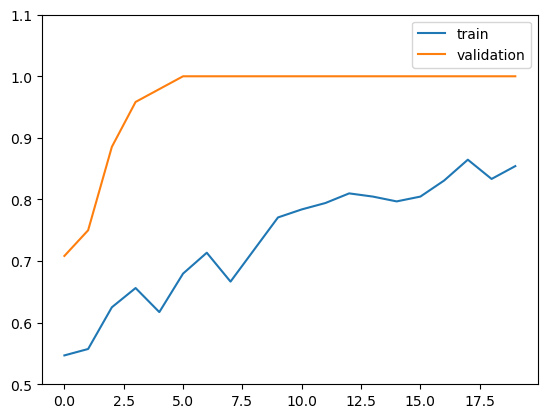

In [41]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.ylim(0.5, 1.1)
    plt.show()
    
show_history(history)

### 📋 Cycle 1. MobileNet 결과

1. val_acc 향상
   - val_acc가 향상되어 6 epoch에서 1.0에 도달했습니다.
2. val_loss 감소
   - val_loss가 꾸준히 감소하여 마지막 에포크에서 0.0984로 낮아졌습니다.
3. acc 증가
   - acc가 1 epoch, 0.56에서 20 epoch, 0.85로 증가했습니다 
4. loss 감소
   - loss가 꾸준히 감소하여 20 epoch에서 0.3285로 낮아졌습니다.
5. learning_rate
   - 일정한 학습률을 유지하면서도 성능이 꾸준히 향상되고 있습니다. 이는 학습률이 적절하게 설정되었음을 의미합니다.
  
∴ 위의 내용을 모델이 잘 학습하고 있으며, 주어진 데이터 세트에서 높은 성능을 달성하고 있음을 보여줍니다.

### 🎯 Cycle 1. MobileNet 실제 예측

In [34]:
from tensorflow.keras.models import load_model

# 모델 로드
model = load_model('./callback_files/PandasBears/mobilenet/weights.018-0.1100-0.8646.weights.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


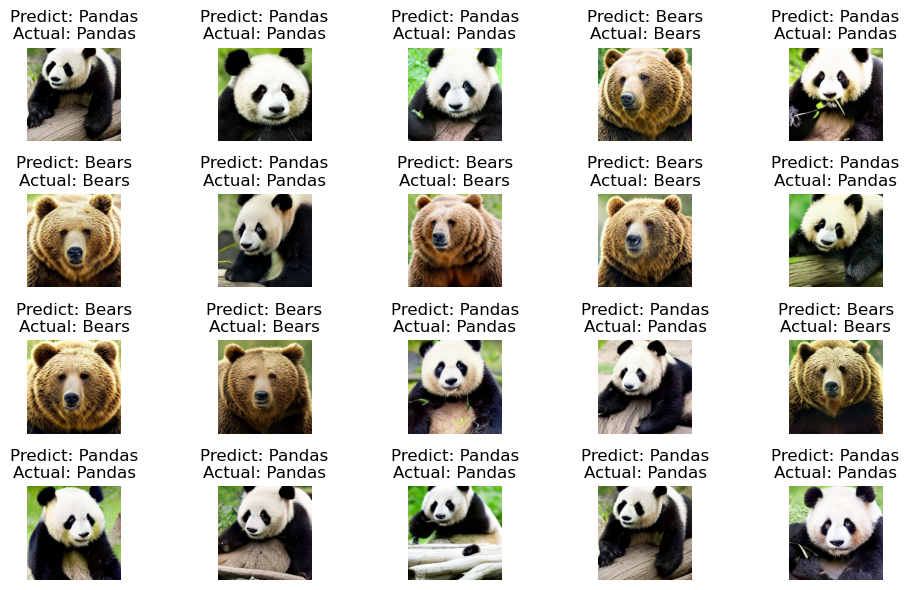

In [42]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

IMAGE_DIR = './datasets/PandasBears/original/'
class_names = ['Bears', 'Pandas']

def load_random_images(image_dir, class_names, num_images=20):
    selected_classes = random.choices(class_names, k=num_images)
    images = []
    labels = []
    
    for class_name in selected_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpeg')]
        selected_image = random.choice(all_images)
        images.append(selected_image)
        labels.append(class_name)
    
    return images, labels

def preprocess_image(image_path, image_size, mode='tf'):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (image_size, image_size))
    preprocessed_image = preprocessing_scaling(resized_image, mode=mode)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    return preprocessed_image

random_images, random_labels = load_random_images(IMAGE_DIR, class_names, num_images=20)

plt.figure(figsize=(10, 6))

for idx, image_path in enumerate(random_images):
    preprocessed_image = preprocess_image(image_path, IMAGE_SIZE, mode='tf')
    predictions = model.predict(preprocessed_image)
    predicted_class = int(predictions[0] > 0.5)
    predicted_class_name = class_names[predicted_class]
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(image)
    plt.title(f"Predict: {predicted_class_name}\nActual: {random_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

---

### 🎯 Cycle 1. MobileNet 실제 예측 결과

<img src="./datasets/PandasBears/tst/predict_pb_mobilenet1.png">
<img src="./datasets/PandasBears/tst/predict_pb_mobilenet2.png">

- original 폴더에서 20개를 랜덤하게 뽑아 예측 했을 때, 20개씩 2번 총 40개를 모두 맞췄습니다.  
- 100퍼센트의 정확도를 나타냅니다.  
- 성능이 매우 우수합니다.  

#### 다음으로는 VGG16을 사용해서 훈련을 진행 해보겠습니다.

### 🖥️ Cycle 2. VGG16

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 8

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.Compose([A.HorizontalFlip(p=0.5), 
                     A.VerticalFlip(p=0.5), 
                     A.OneOf([A.ColorJitter(p=1), 
                              A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)], 
                             p=1)], p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)


# flow_from_dataframe에서 y_col에 들어갈 타겟 데이터는 문자열 타입만 가능하다.
train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 384 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
{'Bears': 0, 'Pandas': 1}
{'Bears': 0, 'Pandas': 1}
{'Bears': 0, 'Pandas': 1}


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/PandasBears/vgg16//weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.keras",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(1.0000e-04), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          25,6

 Total params: 14,740,389 (56.23 MB)

 Trainable params: 14,740,389 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import gc

gc.collect()

0

In [23]:
N_EPOCHS = 30

history = model.fit(train_flow, 
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - acc: 0.6759 - loss: 0.5770 - val_acc: 1.0000 - val_loss: 5.1525e-04 - learning_rate: 1.0000e-04
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - acc: 0.7709 - loss: 0.3332 - val_acc: 1.0000 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - acc: 0.7487 - loss: 0.3328 - val_acc: 1.0000 - val_loss: 2.3123e-05 - learning_rate: 1.0000e-04
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - acc: 0.7271 - loss: 0.3776 - val_acc: 1.0000 - val_loss: 5.5782e-07 - learning_rate: 1.0000e-04
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - acc: 0.7804 - loss: 0.3185 - val_acc: 1.0000 - val_loss: 1.2688e-07 - learning_rate: 1.0000e-04
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - acc: 0.7583 - loss: 0.3217 - val_acc: 1.0000 - val_loss: 1.1989e-07 - learning_rate: 1.0000e-05
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - acc: 0.7356 - loss: 0.3489 - val_acc: 1.0000 - val

In [24]:
model.evaluate(test_flow)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - acc: 1.0000 - loss: 6.7786e-08


[6.380802375360872e-08, 1.0]

In [25]:
model.evaluate(train_flow)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - acc: 0.7489 - loss: 0.3424


[0.3515700101852417, 0.7317708134651184]

In [26]:
model.evaluate(validation_flow)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 1.0000 - loss: 1.0168e-07


[1.1813869349452943e-07, 1.0]

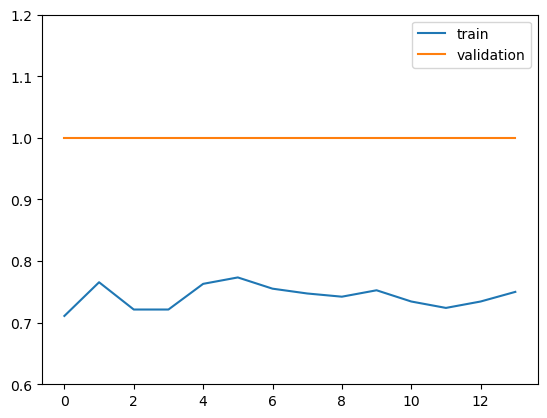

In [29]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.ylim(0.6, 1.2)
    plt.show()
    
show_history(history)

### 📋 Cycle 2. VGG16 결과

1. 높은 val_acc
   - 모든 epoch에서 val_acc가 1.0을 유지하고 있습니다.
2. loss의 감소
   - loss이 초기 epoch부터 꾸준히 감소하고 있습니다.
3. 모델의 성능 향상
   - acc가 점차 증가하고 있습니다.
4. 모델의 안전성
   - val_loss가 매우 낮고 일정하게 유지되고 있습니다.

### 🎯 Cycle 2. VGG16 실제 예측

In [31]:
from tensorflow.keras.models import load_model

# 모델 로드
model = load_model('./callback_files/PandasBears/vgg16/weights.009-0.0000-0.7422.weights.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


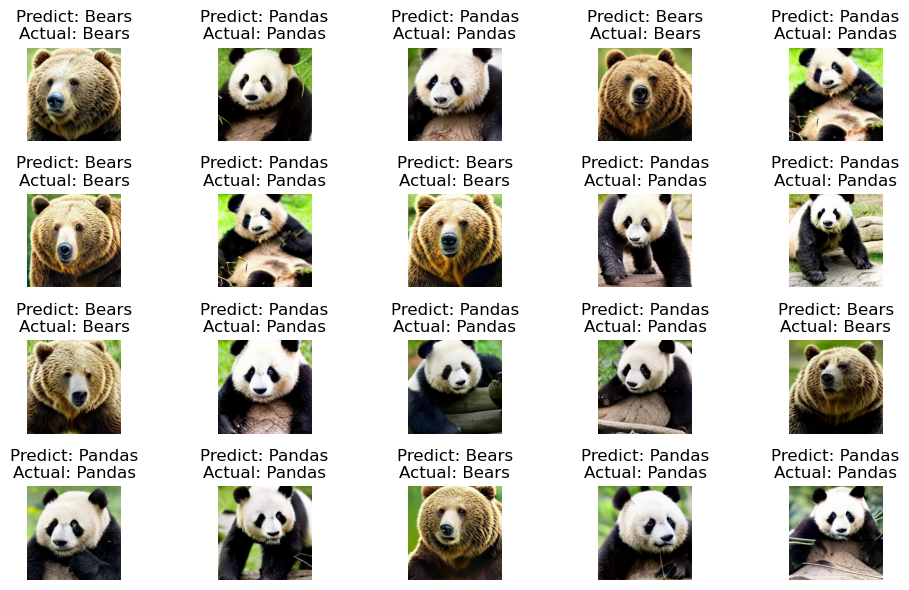

In [33]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

IMAGE_DIR = './datasets/PandasBears/original/'
class_names = ['Bears', 'Pandas']

def load_random_images(image_dir, class_names, num_images=20):
    selected_classes = random.choices(class_names, k=num_images)
    images = []
    labels = []
    
    for class_name in selected_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpeg')]
        selected_image = random.choice(all_images)
        images.append(selected_image)
        labels.append(class_name)
    
    return images, labels

def preprocess_image(image_path, image_size, mode='tf'):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (image_size, image_size))
    preprocessed_image = preprocessing_scaling(resized_image, mode=mode)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    return preprocessed_image

random_images, random_labels = load_random_images(IMAGE_DIR, class_names, num_images=20)

plt.figure(figsize=(10, 6))

for idx, image_path in enumerate(random_images):
    preprocessed_image = preprocess_image(image_path, IMAGE_SIZE, mode='tf')
    predictions = model.predict(preprocessed_image)
    predicted_class = int(predictions[0] > 0.5)
    predicted_class_name = class_names[predicted_class]
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(image)
    plt.title(f"Predict: {predicted_class_name}\nActual: {random_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

---

### 🎯 Cycle 2. VGG16 실제 예측 결과

<img src="./datasets/PandasBears/tst/predict_pb_vgg1.png">
<img src="./datasets/PandasBears/tst/predict_pb_vgg2.png">

- original 폴더에서 20개를 랜덤하게 뽑아 예측 했을 때, 20개씩 2번 총 40개를 모두 맞췄습니다.  
- 100퍼센트의 정확도를 나타냅니다.  
- 성능이 매우 우수합니다.  

---

### 📋 Total Cycle 결론

1. MobileNet과 VGG16 모두 100퍼센트의 정확도를 보여줍니다.
   - 모델 크기와 연산 속도
     > MobileNet이 VGG16보다 상대적으로 파라미터 수와 연산량이 적어 메모리 사용량이 적고 훈련 시간이 더 짧습니다.
   - 메모리 및 저장 공간
     > MobileNet이 VGG16보다 상대적으로 적은 메모리와 적은 저장 공간을 사용합니다.
     
<br>
<strong>∴ 위 요소들을 종합적으로 고려할 때, MobileNet을 사용하는 것이 더 합리적입니다.</strong>